# Credit Card Fraud Detection
 
# Deep Learning in Keras with TensorFlow Backend

This dataset contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
data = pd.read_csv(r"C:\Users\Mohsen\Desktop\Fraud_Detection\creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Check the size of the dataframe
print(data.shape)

# Check to see if any values are null
print(data.isnull().values.any())
# data.isna().any()


(284807, 31)
False


In [4]:
# Class comparison 0=Normal 1=Fraud
pd.value_counts(data['Class'], sort = True)


0    284315
1       492
Name: Class, dtype: int64

# Data Visualization

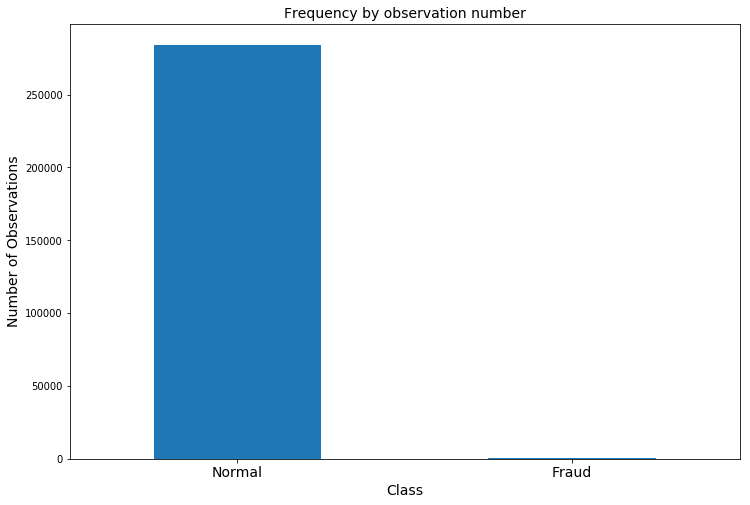

In [5]:
# How imbalanced these two classes are, let's go visual
rcParams['figure.figsize'] = 12, 8

count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS, fontsize=14)
plt.title("Frequency by observation number", fontsize=14)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of Observations", fontsize=14);


In [6]:
normal_df = data[data.Class == 0] #save normal_df observations into a separate df
fraud_df = data[data.Class == 1] #do the same for frauds

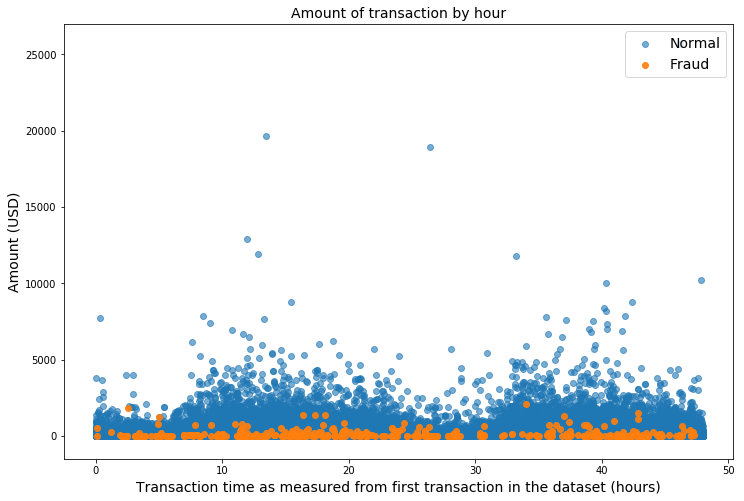

In [7]:
# How do transactions distributed over the time

plt.scatter((normal_df.Time/(60*60)), normal_df.Amount, alpha=0.6, label='Normal')
plt.scatter((fraud_df.Time/(60*60)), fraud_df.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour", fontsize=14)
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)", fontsize=14)
plt.ylabel('Amount (USD)', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

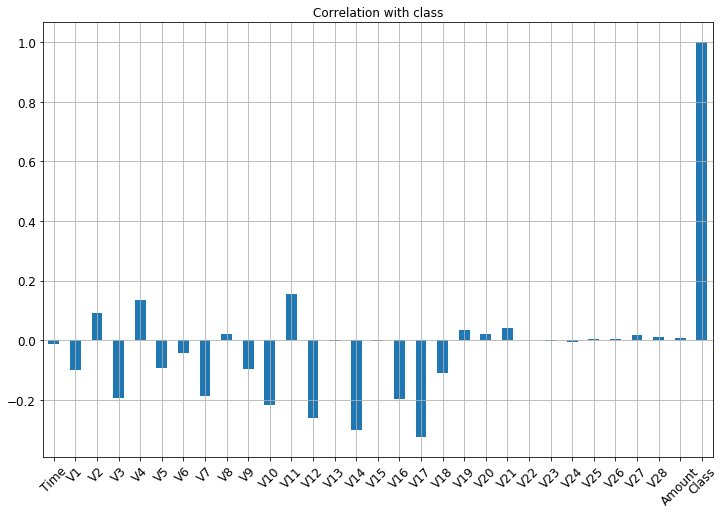

In [8]:
data.corrwith(data.Class).plot.bar(
        title = "Correlation with class", fontsize = 12,
        rot = 45, grid = True)

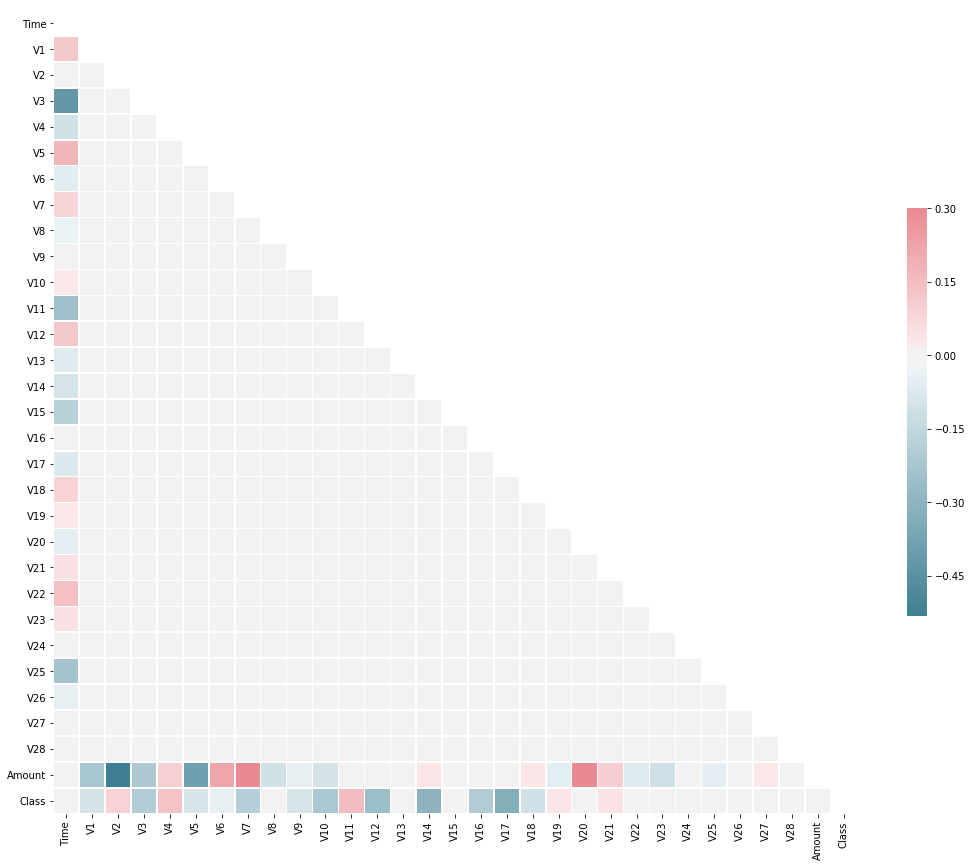

In [9]:
# Generate a mask for the upper triangle

corrmat = data.corr()
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrmat, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Feature Scaling

In [10]:
from sklearn.preprocessing import StandardScaler
data['normalizedAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data = data.drop(['Amount'],axis=1)
data = data.drop(['Time'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normalizedAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


# Model Training

In [11]:
from sklearn.model_selection import train_test_split

X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=0)


# Random forests

In [12]:
## Randomforest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
classifier = RandomForestClassifier(random_state = 0, n_estimators = 100,
                                    criterion = 'entropy')
classifier.fit(X_train, y_train)# Predicting Test Set
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([['Random Forest (n=100)', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

model_results

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest (n=100),0.99952,0.941667,0.768707,0.846442


# Neural Network

In [15]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout


# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(units =15 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 29))
model.add(Dropout(0.3))

# Adding the second hidden layer
model.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.3))

# Adding the output layer
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))



In [16]:
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])# Fitting the ANN to the Training set

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 15)                450       
_________________________________________________________________
dropout_3 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 15)                240       
_________________________________________________________________
dropout_4 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 16        
Total params: 706
Trainable params: 706
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_data=(X_test, y_test))

Train on 199364 samples, validate on 85443 samples
Epoch 1/10
199364/199364 [==============================] - 18s 92us/step - loss: 0.0171 - acc: 0.9982 - val_loss: 0.0044 - val_acc: 0.9983
Epoch 2/10
199364/199364 [==============================] - 16s 82us/step - loss: 0.0045 - acc: 0.9989 - val_loss: 0.0043 - val_acc: 0.9994
Epoch 3/10
199364/199364 [==============================] - 16s 81us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0044 - val_acc: 0.9994
Epoch 4/10
199364/199364 [==============================] - 16s 79us/step - loss: 0.0044 - acc: 0.9993 - val_loss: 0.0045 - val_acc: 0.9993
Epoch 5/10
199364/199364 [==============================] - 15s 76us/step - loss: 0.0043 - acc: 0.9993 - val_loss: 0.0043 - val_acc: 0.9994
Epoch 6/10
199364/199364 [==============================] - 14s 71us/step - loss: 0.0044 - acc: 0.9993 - val_loss: 0.0049 - val_acc: 0.9994
Epoch 7/10
199364/199364 [==============================] - 15s 76us/step - loss: 0.0042 - acc: 0.9993 - val_

In [19]:
# Predicting the Test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
score = model.evaluate(X_test, y_test)
score

85443/85443 [==============================] - 2s 23us/step


[0.00468618560555854, 0.9993562960102056]

In [20]:
#Let's see how our model performed
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.84      0.78      0.81       147

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.92      0.89      0.90     85443
weighted avg       1.00      1.00      1.00     85443



Test Data Accuracy: 0.9994


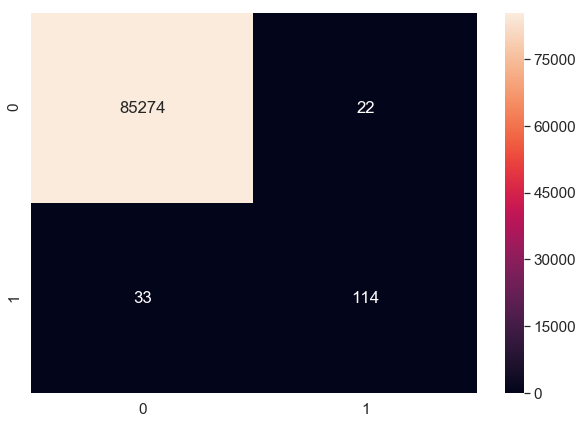

In [21]:
## EXTRA: Confusion Matrix
cm = confusion_matrix(y_test, y_pred) # rows = truth, cols = prediction
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [22]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [23]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


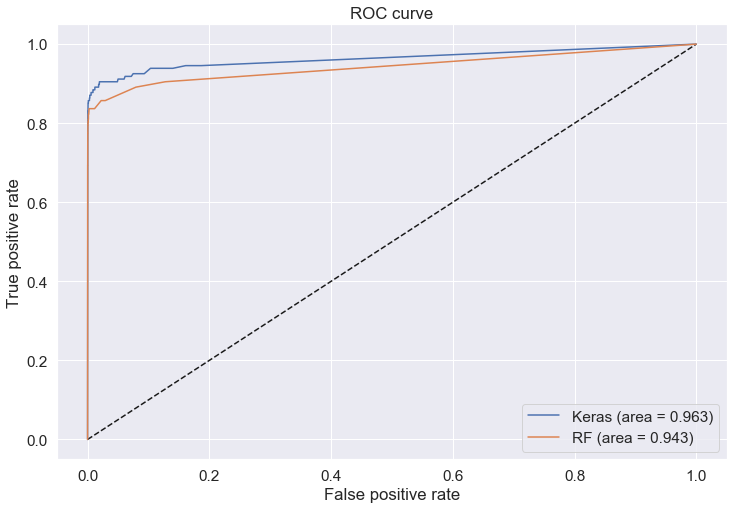

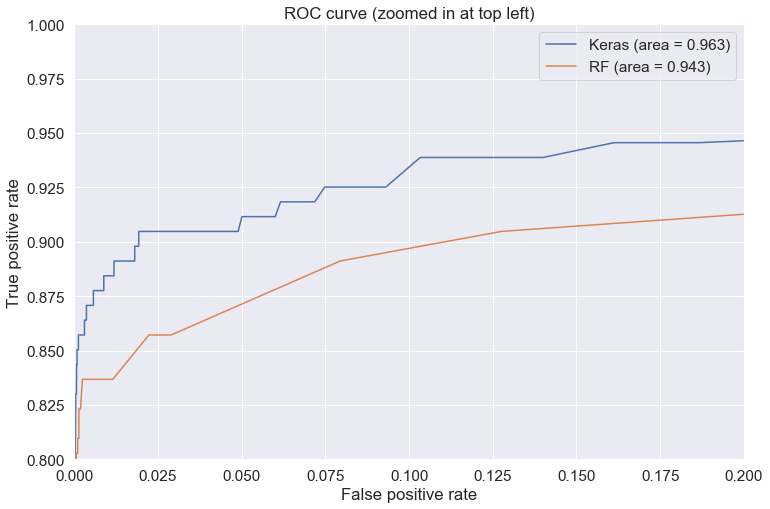

In [25]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()